# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
data_dir = './data' 

transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])

# Create training set and define training dataloader
## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

cat


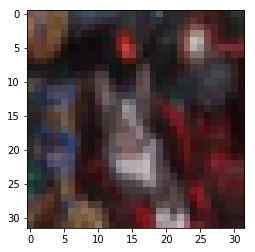

car


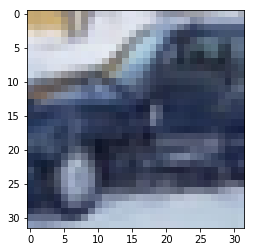

truck


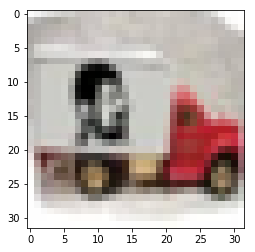

plane


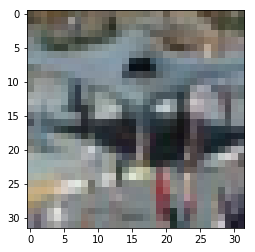

bird


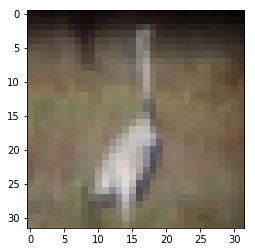

In [4]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
# Reference: https://stackoverflow.com/questions/61039700/using-flatten-in-pytorch-v1-0-sequential-module

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
# Reference: https://www.analyticsvidhya.com/blog/2021/09/convolutional-neural-network-pytorch-implementation-on-cifar10-dataset/

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
## YOUR CODE HERE ##
model = CIFAR10Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

loss_fn = nn.CrossEntropyLoss() #for classification problems
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
## YOUR CODE HERE ##
epoch_losses = [] 
model.train()

for epoch in range(20):
    current_loss = 0.0
    saved_loss = 0.0
    
    for i_batch, data in enumerate(train_loader, 0):
        # get inputs and labels
        inputs, labels = data
        # convert to appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # track the loss
        current_loss += loss.item()
        if i_batch % 2500 == 2499:  # print every 2500 mini-batches
            print(f'epoch {epoch+1} - batch {i_batch+1} | loss: {current_loss/2500:.2f}')
            saved_loss = current_loss
            current_loss = 0.0    
    
    epoch_losses.append(saved_loss/10000)
    
print('\n**** Finished training the model ****')  # print when finished training

epoch 1 - batch 2500 | loss: 1.60
epoch 1 - batch 5000 | loss: 1.19
epoch 1 - batch 7500 | loss: 1.03
epoch 1 - batch 10000 | loss: 0.91
epoch 2 - batch 2500 | loss: 0.80
epoch 2 - batch 5000 | loss: 0.77
epoch 2 - batch 7500 | loss: 0.73
epoch 2 - batch 10000 | loss: 0.70
epoch 3 - batch 2500 | loss: 0.60
epoch 3 - batch 5000 | loss: 0.61
epoch 3 - batch 7500 | loss: 0.58
epoch 3 - batch 10000 | loss: 0.58
epoch 4 - batch 2500 | loss: 0.49
epoch 4 - batch 5000 | loss: 0.51
epoch 4 - batch 7500 | loss: 0.49
epoch 4 - batch 10000 | loss: 0.49
epoch 5 - batch 2500 | loss: 0.40
epoch 5 - batch 5000 | loss: 0.41
epoch 5 - batch 7500 | loss: 0.42
epoch 5 - batch 10000 | loss: 0.43
epoch 6 - batch 2500 | loss: 0.34
epoch 6 - batch 5000 | loss: 0.36
epoch 6 - batch 7500 | loss: 0.36
epoch 6 - batch 10000 | loss: 0.35
epoch 7 - batch 2500 | loss: 0.28
epoch 7 - batch 5000 | loss: 0.29
epoch 7 - batch 7500 | loss: 0.30
epoch 7 - batch 10000 | loss: 0.31
epoch 8 - batch 2500 | loss: 0.24
epoch 8

Plot the training loss (and validation loss/accuracy, if recorded).

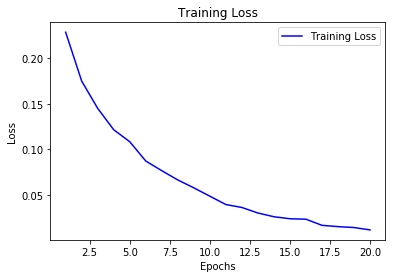

In [9]:
## YOUR CODE HERE ##
epochs = range(1,21)

plt.plot(epochs, epoch_losses, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
## YOUR CODE HERE ##
total, correct = 0, 0

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {(100 * correct / total):.2f} %')

Accuracy: 84.29 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
## YOUR CODE HERE ##
checkpoint = {'model': model,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint_8429.pth')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CIFAR10Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

---
My model achieves an accuracy of 84.29%, surpassing Detectocorp's algorithm by 20.4%. However, when compared to the models described in the literature, my model's performance falls behind. This discrepancy may be attributed to the more complex architectures employed by the models in the literature.

My model is based on a Convolutional Neural Network (CNN), which is commonly utilized for image processing. Specifically, it follows the architecture outlined below:

- The first parameter of the Conv2d module, 3, indicates that the input images are in RGB format with three color channels. The initial output channel size is set to 32, and subsequent Conv2d layers utilize 32 as the input channel size and 64 as the output channel size. The kernel_size parameter governs the filters employed, while the final parameter determines the padding applied during the operation.

- The output of the convolutional operation is then passed through a Rectified Linear Unit (ReLU) activation layer.

- Following two Conv2d layers, a max-pooling operation of size 2x2 is performed.

- To ensure stability and mitigate internal covariate shift, batch normalization is applied to the resulting values. These operations are repeated with additional layers to deepen the network and reduce its size.

- Finally, the output is flattened to create a linear layer that maps the values to ten classes. The probability assigned to each of the ten neurons determines the class to which a given image belongs, with the highest probability indicating the most likely class.

Given the solutions presented in the literature, there is room for improvement in my model. Upon reviewing the papers referenced in the introduction, I speculate that utilizing Recurrent Neural Networks (RNN) or Bidirectional Long Short-Term Memory (BiLSTM) may yield better performance.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).